In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Preprocessing

In [97]:
covid_data = pd.read_excel("/Users/mikaelw/Documents/LOISIRS/Programmation/Python/Machine_learning/datasets/dataset_covid.xlsx")

In [98]:
#Elimination of columns that have more than 91% of nan values
covid_data = covid_data[covid_data.columns[covid_data.isna().sum()/len(covid_data) < 0.90]]

# Elimination of Patient Id column, 3 columns Patient addmited to ... 
covid_data = covid_data.drop(["Patient ID", "Patient addmited to regular ward (1=yes, 0=no)",
                             "Patient addmited to semi-intensive unit (1=yes, 0=no)",
                             "Patient addmited to intensive care unit (1=yes, 0=no)",
                              "Influenza B, rapid test","Influenza A, rapid test"], axis=1) 
# If Influenza rapid test is keep, a lot of nan values "added", already columns for infuenza tests

In [99]:
train_set, test_set = train_test_split(covid_data, test_size=0.20, random_state=0)

In [100]:
# Encoding
def encode(df): 
    encoder = {"not_detected": 0, "negative": 0, "detected": 1, "positive": 1}
    for var in df.select_dtypes("object"):
        df.loc[:,var] = df.loc[:,var].replace(encoder)
    return df

In [101]:
# Treatement of Missing values
def treat_miss_values(df):
    df = df.dropna(axis=0)
    return df

In [102]:
def preprocessing(df):
    df = encode(df)
    df = treat_miss_values(df)
    X = df.drop("SARS-Cov-2 exam result", axis = 1)
    y = df["SARS-Cov-2 exam result"]
    return X, y

In [103]:
X_train, y_train = preprocessing(train_set)
X_test, y_test = preprocessing(test_set)

/Users/mikaelw/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [104]:
def evaluation(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_pred, y_test))
    train_sizes_abs, train_scores, test_scores= learning_curve(model, X_train, y_train,
                                                               train_sizes=np.linspace(0.2, 1, 10),
                                                              cv=5, scoring ="f1")
    plt.figure()
    plt.plot(train_sizes_abs,train_scores.mean(axis=1), label="train score (f1)")
    plt.plot(train_sizes_abs, test_scores.mean(axis=1), label="val score (f1)")
    plt.legend()

# Modeling

              precision    recall  f1-score   support

           0       0.98      0.88      0.93        60
           1       0.42      0.83      0.56         6

    accuracy                           0.88        66
   macro avg       0.70      0.86      0.74        66
weighted avg       0.93      0.88      0.90        66

              precision    recall  f1-score   support

           0       0.96      0.91      0.94        57
           1       0.58      0.78      0.67         9

    accuracy                           0.89        66
   macro avg       0.77      0.85      0.80        66
weighted avg       0.91      0.89      0.90        66

              precision    recall  f1-score   support

           0       0.98      0.90      0.94        59
           1       0.50      0.86      0.63         7

    accuracy                           0.89        66
   macro avg       0.74      0.88      0.78        66
weighted avg       0.93      0.89      0.91        66



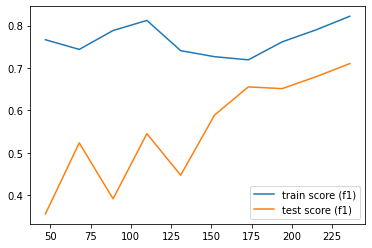

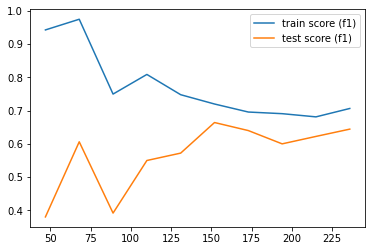

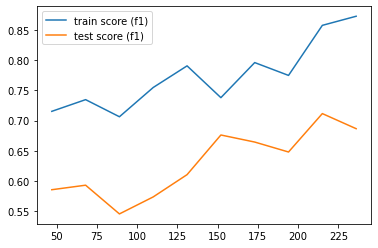

In [105]:
# Choosing the best model :
SV = make_pipeline(StandardScaler(), SVC(random_state=0))
SGD = make_pipeline(StandardScaler(), SGDClassifier(random_state=0))
Bagclas = make_pipeline(StandardScaler(), BaggingClassifier(base_estimator=KNeighborsClassifier(), n_estimators=100))
models_to_test = [SV, SGD, Bagclas]
for model in models_to_test:
    evaluation(model, X_train, X_test, y_train, y_test)

# Optimization

In [110]:
params_grid = {"sgdclassifier__loss": ["hinge", "modified_huber", "squared_hinge", "perceptron"],
              "sgdclassifier__penalty": ["l2", "l1", "elasticnet"]}
grid = GridSearchCV(SGD, params_grid, scoring = "f1", cv=4)
grid.fit(X_train, y_train)
model_opt = grid.best_estimator_
grid.best_params_

{'sgdclassifier__loss': 'modified_huber',
 'sgdclassifier__penalty': 'elasticnet'}

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        54
           1       0.75      0.75      0.75        12

    accuracy                           0.91        66
   macro avg       0.85      0.85      0.85        66
weighted avg       0.91      0.91      0.91        66



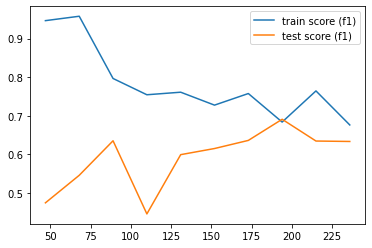

In [111]:
evaluation(model_opt, X_train, X_test, y_train, y_test)

# Conclusion